#**Nhận dạng các quân cờ vua**

##**1.Thu thập dữ liệu**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**1.1 Import thư viện**

In [2]:
!pip install split-folders

import splitfolders
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)


2.17.0


###**1.3 Kiểm tra thông tin data gốc**

Tổng số ảnh: 556
Images in folder: /content/drive/MyDrive/chess/dataset/Bishop
Images in folder: /content/drive/MyDrive/chess/dataset/King
Images in folder: /content/drive/MyDrive/chess/dataset/Knight
Images in folder: /content/drive/MyDrive/chess/dataset/Pawn
Images in folder: /content/drive/MyDrive/chess/dataset/Queen
Images in folder: /content/drive/MyDrive/chess/dataset/Rook


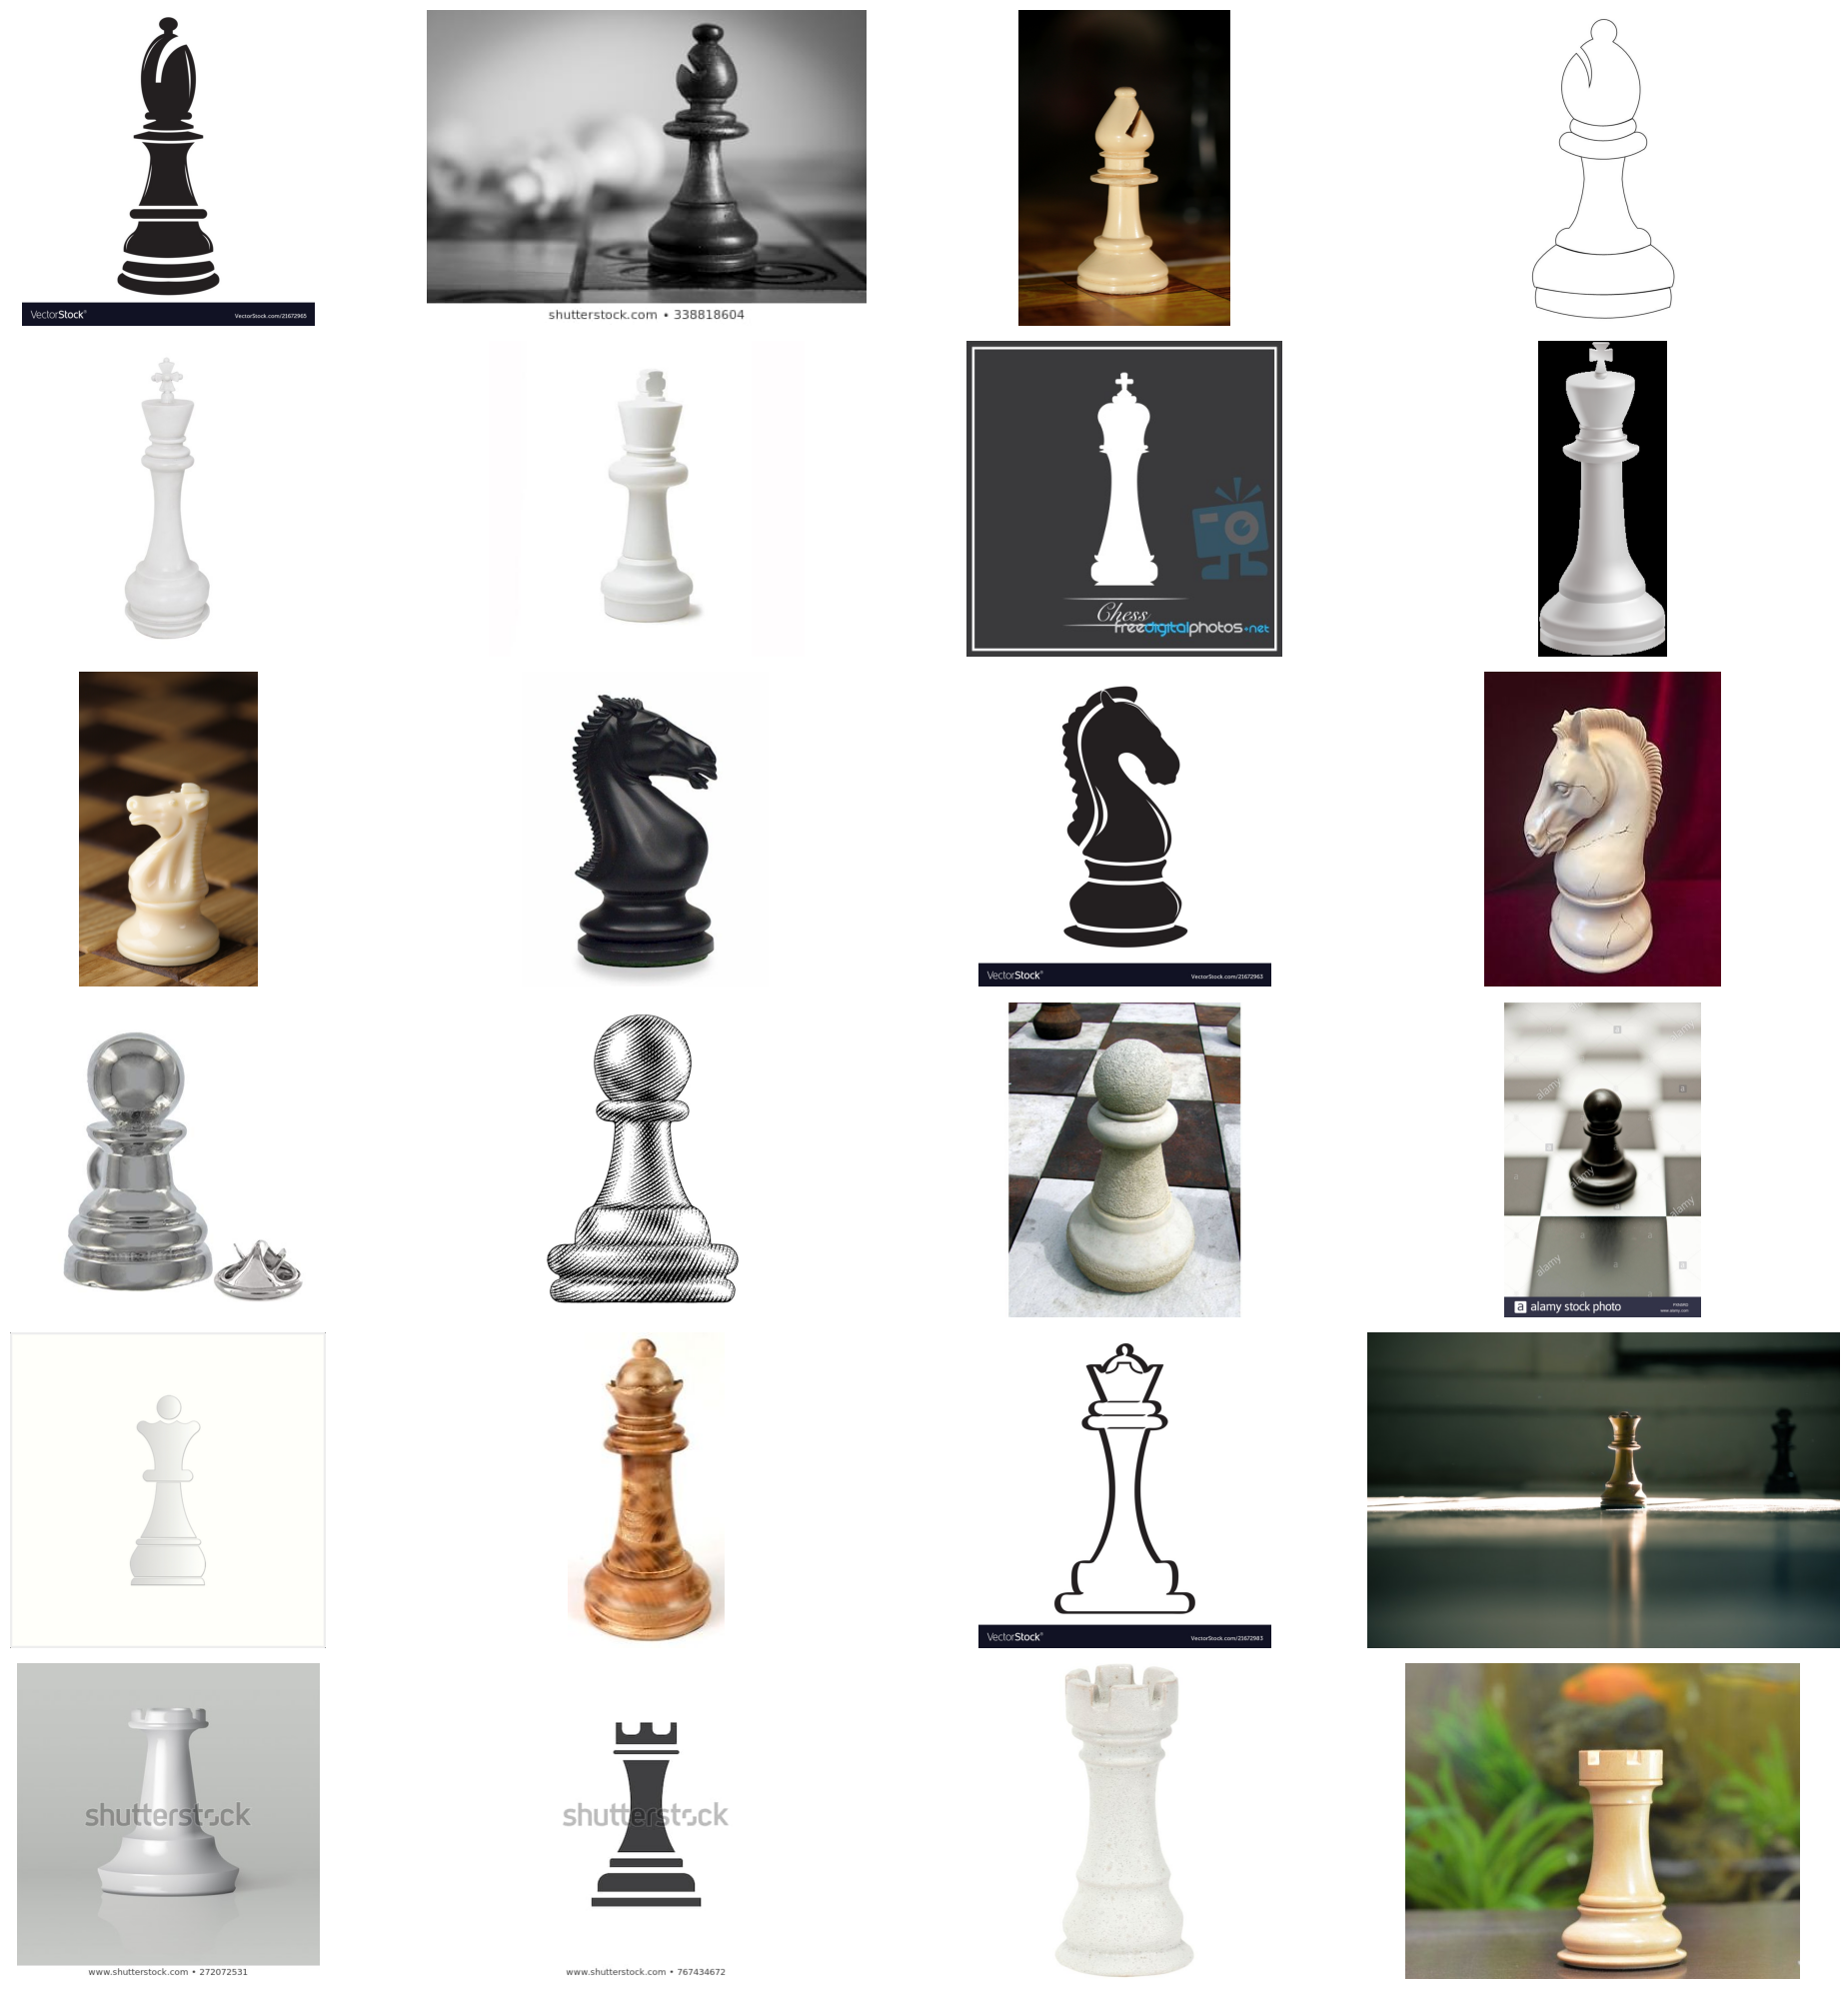

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
folders = [
    "/content/drive/MyDrive/chess/dataset/Bishop",
    "/content/drive/MyDrive/chess/dataset/King",
    "/content/drive/MyDrive/chess/dataset/Knight",
    "/content/drive/MyDrive/chess/dataset/Pawn",
    "/content/drive/MyDrive/chess/dataset/Queen",
    "/content/drive/MyDrive/chess/dataset/Rook"
]

total_images = 0

# Lặp qua từng thư mục và tính tổng số ảnh
for folder in folders:
    image_files = os.listdir(folder)
    total_images += len(image_files)

print(f"Tổng số ảnh: {total_images}")

fig, axs = plt.subplots(len(folders), 4, figsize=(20, 20))

for i, folder in enumerate(folders):
    print(f"Images in folder: {folder}")
    image_files = os.listdir(folder)[:4]
    for j, image_file in enumerate(image_files):
        # Đường dẫn đầy đủ đến ảnh
        image_path = os.path.join(folder, image_file)
        # Hiển thị ảnh
        img = mpimg.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

###**1.4 Sử dụng các kỹ thuật tăng cường dữ liệu (data augmentation) và lưu vào thư mục augmented**

In [5]:
from PIL import Image
import os
import numpy as np

# Đường dẫn đến các thư mục chứa ảnh cần tăng cường dữ liệu
image_directories = [
    "/content/drive/MyDrive/chess/dataset/Bishop",
    "/content/drive/MyDrive/chess/dataset/King",
    "/content/drive/MyDrive/chess/dataset/Knight",
    "/content/drive/MyDrive/chess/dataset/Pawn",
    "/content/drive/MyDrive/chess/dataset/Queen",
    "/content/drive/MyDrive/chess/dataset/Rook"
]


# Khởi tạo ImageDataGenerator với các phương pháp tăng cường dữ liệu
datagen = ImageDataGenerator(
    rotation_range=40,#Xoay ảnh trong khoảng góc độ đã chỉ định
    width_shift_range=0.2,#Dịch chuyển ảnh theo chiều ngang theo tỉ lệ của chiều rộng của ảnh
    height_shift_range=0.2,#Dịch chuyển ảnh theo chiều dọc theo tỉ lệ của chiều cao của ảnh
    shear_range=0.2,#Cắt biến dạng ảnh
    zoom_range=0.2,#Phóng to hoặc thu nhỏ ảnh
    horizontal_flip=True,#Lật ảnh theo chiều ngang
    fill_mode='nearest'#Sử dụng giá trị gần nhất để điền vào các pixel bị rỗng.
)

# Đường dẫn đến thư mục lưu ảnh đã được tăng cường
output_dir = "/content/drive/MyDrive/chess/augmented"

# Tạo thư mục để lưu ảnh đã được tăng cường
os.makedirs(output_dir, exist_ok=True)

# Lặp qua từng thư mục chứa ảnh và tạo các biến thể mới
for directory in image_directories:
    class_name = os.path.basename(directory)  # Lấy tên lớp từ tên thư mục
    output_class_dir = os.path.join(output_dir, class_name)  # Đường dẫn đến thư mục đích của lớp

    # Tạo thư mục đích cho lớp nếu chưa tồn tại
    os.makedirs(output_class_dir, exist_ok=True)

    # Lặp qua từng ảnh trong thư mục hiện tại
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)  # Đường dẫn đến ảnh gốc
        img = Image.open(img_path)  # Load ảnh gốc
        img = img.convert("RGB")  # Chuyển đổi thành ảnh có 3 kênh màu RGB
        img = img.resize((224, 224))  # Điều chỉnh kích thước thành 224x224 pixels

        # Chuyển ảnh thành mảng numpy
        img = np.array(img)
        img = img.reshape((1,) + img.shape)

        # Tạo 7 biến thể cho mỗi ảnh gốc và lưu vào thư mục đích
        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=output_class_dir, save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= 7:  # Tạo 7 biến thể cho mỗi ảnh gốc
                break


###**1.5 Chia dataset thành tập train, test, valid với tỉ lệ 80% train, 10% test, và 10% valid và lưu vào thư mục dataset**

In [17]:
import splitfolders

input_folder = "/content/drive/MyDrive/chess/augmented"  # Thay đổi theo thư mục dataset của bạn
output_folder = "/content/drive/MyDrive/chess/dataset_model"  # Thư mục chứa kết quả sau khi chia

# Tỉ lệ chia: 80% train, 10% validation, 10% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1))




Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  9.17 files/s]
Copying files: 10 files [00:00, 53.57 files/s]
Copying files: 19 files [00:00, 67.07 files/s]
Copying files: 29 files [00:00, 79.34 files/s]
Copying files: 38 files [00:00, 81.00 files/s]
Copying files: 47 files [00:00, 78.33 files/s]
Copying files: 56 files [00:00, 80.08 files/s]
Copying files: 66 files [00:00, 84.53 files/s]
Copying files: 75 files [00:00, 84.20 files/s]
Copying files: 84 files [00:01, 83.14 files/s]
Copying files: 93 files [00:01, 80.77 files/s]
Copying files: 103 files [00:01, 81.97 files/s]
Copying files: 113 files [00:01, 86.58 files/s]
Copying files: 122 files [00:01, 86.16 files/s]
Copying files: 131 files [00:01, 82.74 files/s]
Copying files: 140 files [00:01, 81.17 files/s]
Copying files: 149 files [00:01, 72.90 files/s]
Copying files: 159 files [00:02, 79.17 files/s]
Copying files: 168 files [00:02, 69.46 files/s]
Copying files: 176 files [00:02, 71.28 files/s]
Copying f

In [20]:
BASE_PATH = "/content/drive/MyDrive/chess/dataset_model"
TRAIN_PATH = '/content/drive/MyDrive/chess/dataset_model/train'
VALID_PATH = '/content/drive/MyDrive/chess/dataset_model/val'
TEST_PATH = '/content/drive/MyDrive/chess/dataset_model/test'
CLASSES = ['Bishop', 'King','Knight', 'Pawn','Queen', 'Rook']
IMG_SIZE = (224,224)

In [21]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    Path.cwd() / BASE_PATH / TRAIN_PATH,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

validation_dataset = image_dataset_from_directory(
    Path.cwd() / BASE_PATH / VALID_PATH,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    Path.cwd() / BASE_PATH / TEST_PATH,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

for images_batch, labels_batch in train_dataset:
    print("images batch shape:", images_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

Found 3020 files belonging to 6 classes.
Found 376 files belonging to 6 classes.
Found 382 files belonging to 6 classes.
images batch shape: (32, 224, 224, 3)
labels batch shape: (32, 6)


##**2.Phân lớp**

###**2.1 VGG16 transferlearning**

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Khai báo các đường dẫn tới dữ liệu
train_dir = '/content/drive/MyDrive/chess/dataset_model/train'
val_dir = '/content/drive/MyDrive/chess/dataset_model/val'
test_dir = '/content/drive/MyDrive/chess/dataset_model/test'

# Kích thước ảnh đầu vào
input_shape = (224, 224, 3)

# Số lớp phân loại
num_classes = 6


def create_model(learning_rate=0.001): # Add learning_rate as an argument with a default value
    # Load pretrained model 'VGG16'
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3))

    base_model.trainable = False

    inputs = Input(shape=input_shape)


    x = base_model(inputs)

    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(6, activation='softmax', kernel_initializer='glorot_normal')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Use the learning_rate argument when creating the optimizer
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Tạo generators cho dữ liệu train và validation
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical')
model = create_model(learning_rate=0.001) # Call create_model with the desired learning rate
model.summary()

Found 3020 images belonging to 6 classes.
Found 376 images belonging to 6 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,141,062 (80.65 MB)

 Trainable params: 6,425,350 (24.51 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

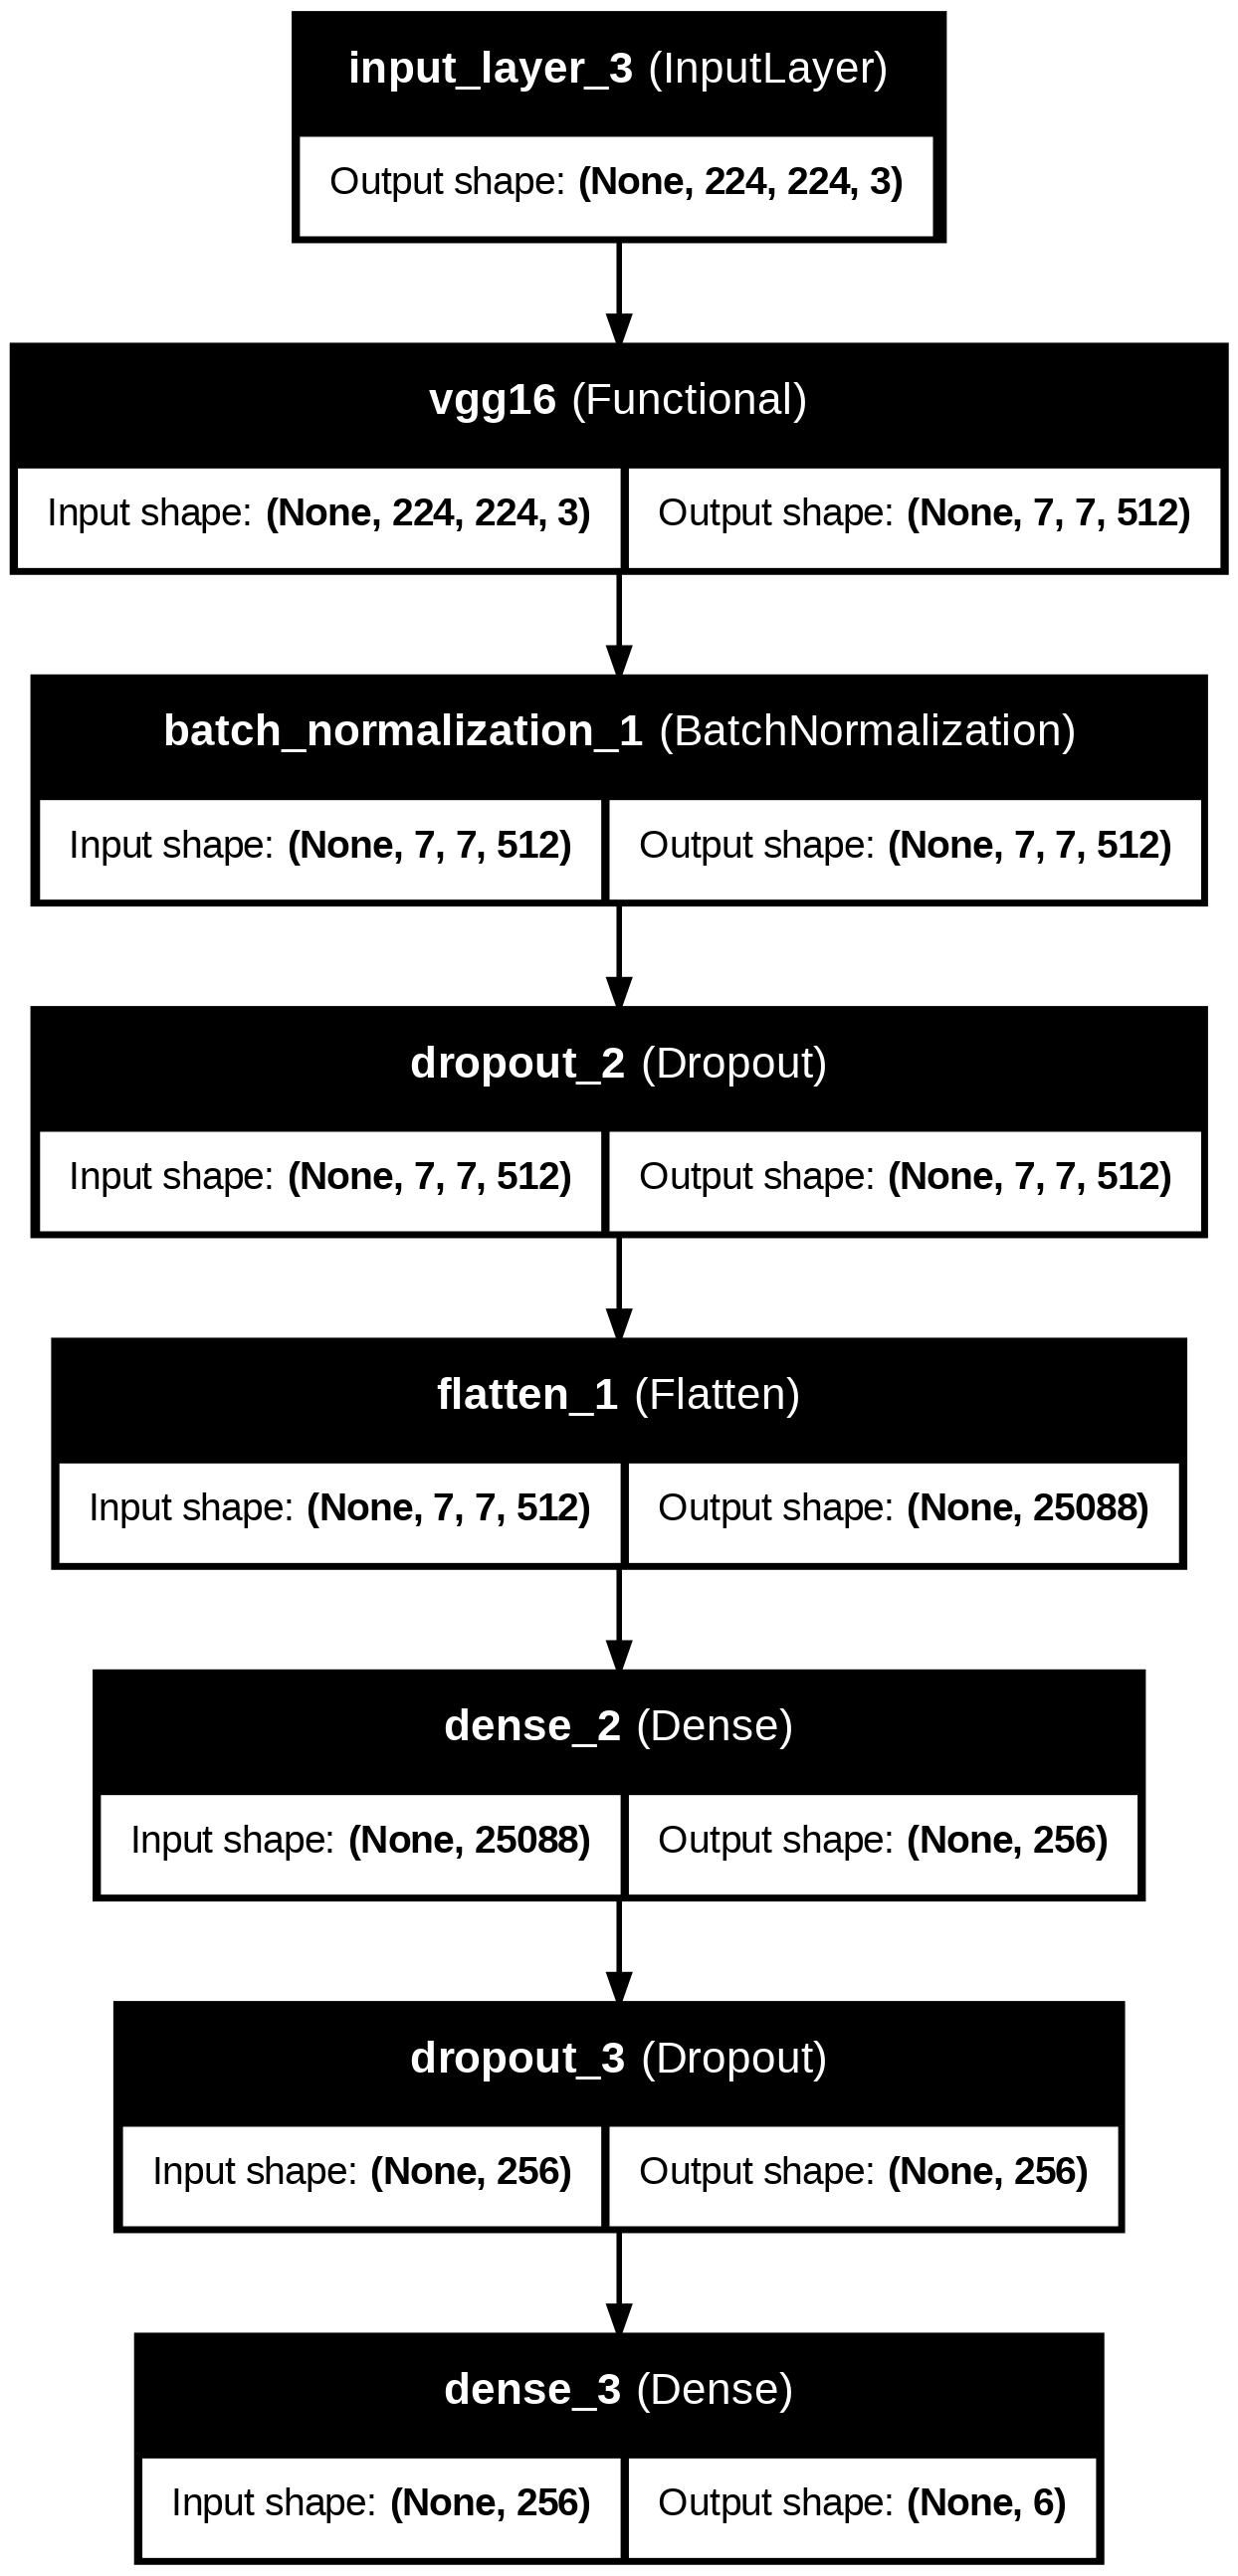

In [14]:
from tensorflow.keras.utils import plot_model

# Trực quan hóa kiến ​​trúc mô hình
plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
# Huấn luyện mô hình
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // train_generator.batch_size,
      epochs=100,
      validation_data=val_generator,
      validation_steps=val_generator.samples // val_generator.batch_size)

# Đánh giá mô hình trên tập test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)
# Lưu mô hình dưới dạng file .h5
model.save("/content/drive/MyDrive/chess/vgg16_model.h5")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.4906 - loss: 2.1270 - val_accuracy: 0.6307 - val_loss: 1.1574
Epoch 2/100
 1/94 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.7812 - loss: 0.6748

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7812 - loss: 0.6748 - val_accuracy: 0.6250 - val_loss: 1.1679
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7923 - loss: 0.5653 - val_accuracy: 0.7727 - val_loss: 0.7825
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.7304 - val_accuracy: 0.8333 - val_loss: 0.5125
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8748 - loss: 0.3332 - val_accuracy: 0.8011 - val_loss: 0.6776
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.2653 - val_accuracy: 0.8750 - val_loss: 0.4018
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.9146 - loss: 0.2270 - val_accuracy: 0.8267 - val_loss: 0.7100
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.4419 - val_accuracy: 0.7917 - val_loss: 0.5137
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.9289 - loss: 0.1995 - val_accuracy: 0.7983 - v

Test accuracy: 0.8507853150367737


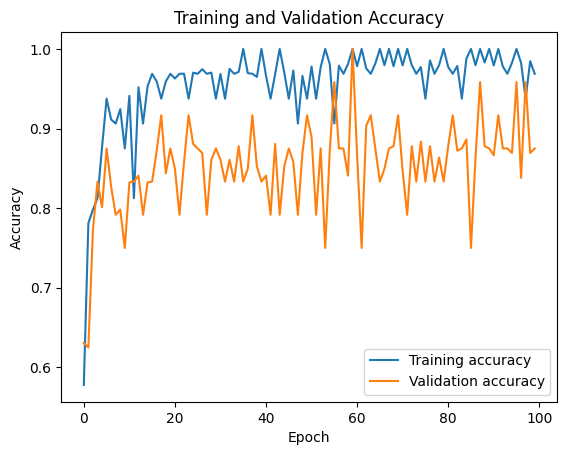

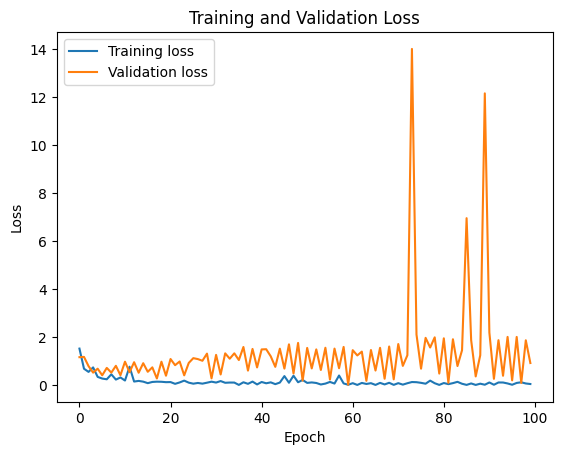

In [16]:

import matplotlib.pyplot as plt

# Trực quan hóa độ chính xác trên tập huấn luyện và tập validation
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Trực quan hóa độ mất mát trên tập huấn luyện và tập validation
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




###**2.3 Resnet TransferLearning**

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Tạo mô hình ResNet
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng các lớp của ResNet
for layer in resnet_model.layers:
    layer.trainable = False

# Thêm lớp Dense đầu ra
x = GlobalAveragePooling2D()(resnet_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

# Tạo mô hình tổng thể
model = Model(inputs=resnet_model.input, outputs=output)

# Compile mô hình
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.5510 - loss: 1.3018 - val_accuracy: 0.8032 - val_loss: 0.5079
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.8676 - loss: 0.3568 - val_accuracy: 0.8777 - val_loss: 0.3497
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9252 - loss: 0.2183 - val_accuracy: 0.9069 - val_loss: 0.2671
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9642 - loss: 0.1232 - val_accuracy: 0.9122 - val_loss: 0.2235
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9863 - loss: 0.0715 - val_accuracy: 0.8963 - val_loss: 0.2727
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9774 - loss: 0.0758 - val_accuracy: 0.9415 - val_loss: 0.1822
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.9948 - loss: 0.0321 - val_accuracy: 0.9309 - val_loss: 0.1875
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9966 - loss: 0.0247 - val_accu

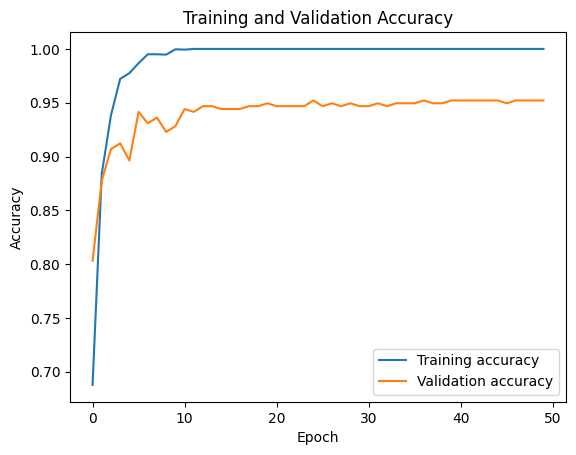

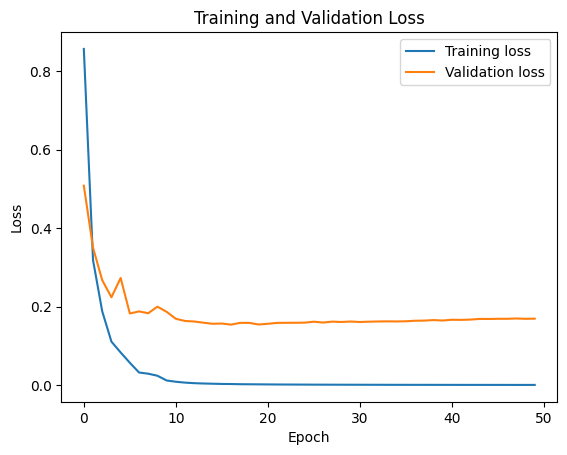

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 419ms/step - accuracy: 0.9636 - loss: 0.1151


Test accuracy: 0.9712041616439819


In [24]:
# Huấn luyện mô hình
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=50)
# Vẽ đồ thị độ chính xác trên tập huấn luyện và tập validation
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ đồ thị độ mất mát trên tập huấn luyện và tập validation
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Đánh giá mô hình trên tập test
test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)

# Lưu mô hình dưới dạng file .h5
model.save("/content/drive/MyDrive/chess/resnet_model.h5")

###**2.4 Sử dụng mô hình để dự đoán lớp**


In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load mô hình từ file .h5
model_path = "/content/drive/MyDrive/chess/vgg16_model.h5"
model = load_model(model_path)

# Đường dẫn đến hình ảnh cần dự đoán
img_paths = [
    '/content/drive/MyDrive/chess/dataset_model/test/Bishop/aug_0_2472.jpg',
    '/content/drive/MyDrive/chess/dataset_model/test/Queen/aug_0_7518.jpg'
]

# Kích thước ảnh đầu vào của mô hình
input_shape = (224, 224)

# Chuẩn bị hình ảnh đầu vào và dự đoán lớp
for img_path in img_paths:
    # Đọc và tiền xử lý hình ảnh
    img = image.load_img(img_path, target_size=input_shape)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Mở rộng chiều để tạo batch

    # Chuẩn hóa dữ liệu
    img_array = img_array / 255.0

    # Dự đoán lớp của hình ảnh
    predictions = model.predict(img_array)

    # Lấy chỉ số của lớp có xác suất cao nhất
    predicted_class_index = np.argmax(predictions)

    # Lấy tên lớp tương ứng với chỉ số dự đoán
    predicted_class = CLASSES[predicted_class_index]

    print("Predicted class for", img_path, ":", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class for /content/drive/MyDrive/chess/dataset_model/test/Bishop/aug_0_2472.jpg : Bishop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class for /content/drive/MyDrive/chess/dataset_model/test/Queen/aug_0_7518.jpg : Queen


###**2.5 Streamlit**

### 2.5.1.Cài đặt và tạo file app.py

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [31]:
%%writefile /content/drive/MyDrive/chess/app.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Đường dẫn đến mô hình đã được huấn luyện
model_path = "/content/drive/MyDrive/chess/vgg16_model.h5"

# Load mô hình từ file .h5
model = load_model(model_path)

# Kích thước ảnh đầu vào của mô hình
input_shape = (224, 224)

# Đường dẫn đến thư mục chứa dữ liệu
data_dir = "/content/drive/MyDrive/chess/dataset_model/train"

# Danh sách các lớp dựa trên tên thư mục trong thư mục chứa dữ liệu
CLASSES = sorted(os.listdir(data_dir))

# Chuẩn bị hình ảnh đầu vào và dự đoán lớp
def predict_class(img_path):
    # Đọc và tiền xử lý hình ảnh
    img = image.load_img(img_path, target_size=input_shape)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Mở rộng chiều để tạo batch

    # Chuẩn hóa dữ liệu
    img_array = img_array / 255.0

    # Dự đoán lớp của hình ảnh
    predictions = model.predict(img_array)

    # Lấy chỉ số của lớp có xác suất cao nhất
    predicted_class_index = np.argmax(predictions)

    # Trả về tên lớp tương ứng với chỉ số dự đoán
    return CLASSES[predicted_class_index]

# Tiêu đề cho ứng dụng Streamlit
st.title('Chess Piece Recognition')

# Widget để upload hình ảnh từ máy tính
uploaded_file = st.file_uploader("Upload Image", type=['jpg', 'jpeg', 'png'])

# Nếu người dùng đã upload ảnh, thực hiện dự đoán và hiển thị kết quả
if uploaded_file is not None:
    # Hiển thị hình ảnh đã upload
    st.image(uploaded_file, caption='Uploaded Image.', use_column_width=True)

    # Thực hiện dự đoán lớp của hình ảnh
    predicted_class = predict_class(uploaded_file)

    # Hiển thị kết quả dự đoán
    st.write("Predicted class:", predicted_class)



Writing /content/drive/MyDrive/chess/app.py


In [32]:
!npm install localtunnel


added 22 packages, and audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues, run:
  npm audit fix

Run `npm audit` for details.


In [33]:
!streamlit run /content/drive/MyDrive/chess/app.py &>/content/logs.txt &


### 2.5.2Chạy streamlit app

In [34]:
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com
#password để chạy app là dòng đầu tiên

34.125.249.47
your url is: https://nice-onions-float.loca.lt


##**3.Phân đoạn hình ảnh**

###**3.1 Áp dụng Canny Edge Detection để tạo mask,tạo data lưu vào mask_images**

In [35]:
import cv2
import os
import numpy as np
from pathlib import Path
import shutil  # Thêm thư viện shutil để sao chép các tệp

# Đường dẫn đến thư mục chứa ảnh gốc
source_dir = Path("/content/drive/MyDrive/chess/dataset")

# Đường dẫn đến thư mục chính lưu ảnh và mặt nạ
main_dir = Path("/content/drive/MyDrive/chess/mask_images")
images_dir = main_dir / "images"
mask_dir = main_dir / "mask"

# Tạo thư mục
images_dir.mkdir(parents=True, exist_ok=True)
mask_dir.mkdir(parents=True, exist_ok=True)

def create_mask_and_copy_image(image_path, mask_path, image_dest_path):
    # Đọc ảnh
    image = cv2.imread(str(image_path))
    # Chuyển đổi sang ảnh xám
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Áp dụng Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Lưu ảnh mặt nạ
    cv2.imwrite(str(mask_path), edges)
    # Sao chép ảnh gốc vào thư mục đích
    shutil.copy(image_path, image_dest_path)

# Duyệt qua từng loại quân cờ và tạo mặt nạ cho mỗi ảnh
for piece_type in source_dir.iterdir():
    # Tạo thư mục cho từng loại quân cờ trong thư mục ảnh và mặt nạ
    piece_images_dir = images_dir / piece_type.name
    piece_mask_dir = mask_dir / piece_type.name
    piece_images_dir.mkdir(exist_ok=True)
    piece_mask_dir.mkdir(exist_ok=True)

    # Duyệt qua từng ảnh và tạo mặt nạ
    for image_path in piece_type.glob("*.jpg"):  # Điều chỉnh định dạng file nếu cần
        mask_path = piece_mask_dir / image_path.name
        image_dest_path = piece_images_dir / image_path.name
        create_mask_and_copy_image(image_path, mask_path, image_dest_path)

print("Hoàn thành việc tạo mặt nạ và sao chép ảnh cho dataset.")


Hoàn thành việc tạo mặt nạ và sao chép ảnh cho dataset.


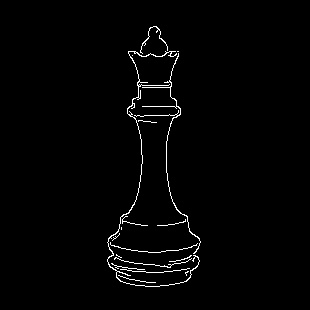

In [43]:
import cv2
from google.colab.patches import cv2_imshow
# Đường dẫn của 2 hình ảnh cần hiển thị
img_path1 = '/content/drive/MyDrive/chess/mask_images/mask/Queen/00000005.jpg'
img_path2 = '/content/drive/MyDrive/chess/mask_images/mask/Bishop/00000008.jpg'


# Đọc và hiển thị hình ảnh
img1 = cv2.imread(img_path1)  # Đọc hình ảnh từ đường dẫn
cv2_imshow(img1)  # Hiển thị hình ảnh




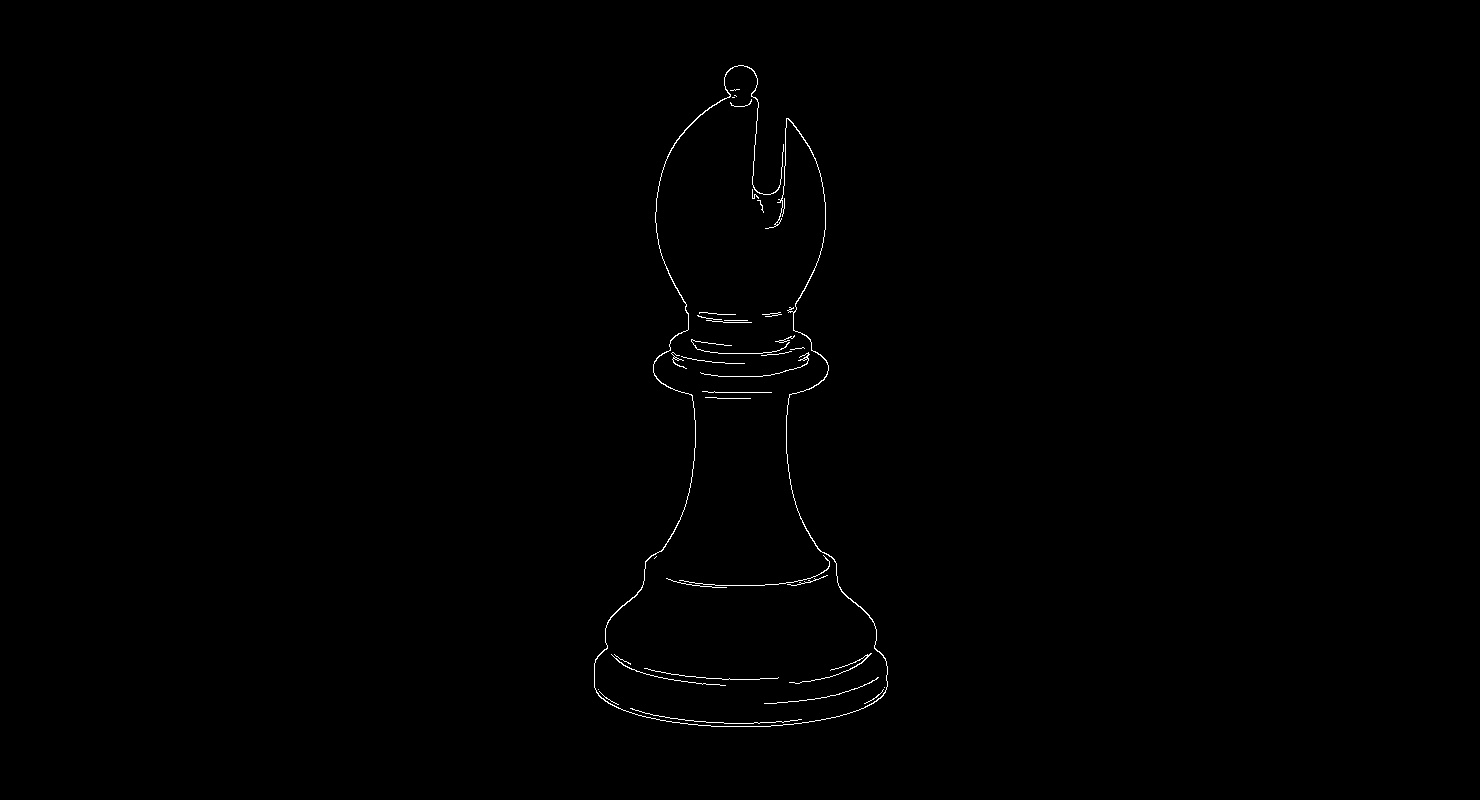

In [44]:
img2 = cv2.imread(img_path2)  # Đọc hình ảnh từ đường dẫn
cv2_imshow(img2)  # Hiển thị hình ảnh

###**3.2 Chia thành 3 tập train test valid theo tỉ lệ 80-10-10, lưu vào thư mục unet**


In [51]:
!pip install split-folders

In [46]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Định nghĩa đường dẫn
source_images_dir = Path("/content/drive/MyDrive/chess/mask_images/images")
source_masks_dir = Path("/content/drive/MyDrive/chess/mask_images/mask")
split_dir = Path("/content/drive/MyDrive/chess/data_unet")

# Tạo thư mục split
for split in ['train', 'test', 'valid']:
    for class_name in ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']:
        (split_dir / split / 'images1' / class_name).mkdir(parents=True, exist_ok=True)
        (split_dir / split / 'mask1' / class_name).mkdir(parents=True, exist_ok=True)

# Chia và sao chép dữ liệu
for class_name in ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']:
    images = list((source_images_dir / class_name).glob('*.jpg'))
    masks = list((source_masks_dir / class_name).glob('*.jpg'))

    images_train, images_temp, masks_train, masks_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
    images_valid, images_test, masks_valid, masks_test = train_test_split(images_temp, masks_temp, test_size=0.5, random_state=42)

    for image_path, mask_path, split in zip([images_train, images_valid, images_test],
                                             [masks_train, masks_valid, masks_test],
                                             ['train', 'valid', 'test']):
        for img_path, msk_path in zip(image_path, mask_path):
            shutil.copy(img_path, split_dir / split / 'images1' / class_name / img_path.name)
            shutil.copy(msk_path, split_dir / split / 'mask1' / class_name / msk_path.name)

print("Hoàn thành việc chia dữ liệu.")


Hoàn thành việc chia dữ liệu.


###**3.3 Định nghĩa Hàm Đọc và Xử Lý Dữ Liệu**

In [49]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Định nghĩa hàm parse_image để đọc và xử lý ảnh và mặt nạ
def parse_image(img_path, mask_path):
    # Đọc và xử lý ảnh
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # img = tf.image.rgb_to_grayscale(img)  # Remove this line to keep the image in RGB format
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0  # Chuẩn hóa về khoảng [0, 1]

    # Đọc và xử lý mặt nạ
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = mask / 255.0

    return img, mask

# Hàm load_dataset để tạo dataset từ các đường dẫn ảnh và mặt nạ
def load_dataset(img_dir, mask_dir, pattern='*.jpg'):
    # Tạo một danh sách để giữ các cặp ảnh và mặt nạ
    img_paths, mask_paths = [], []

    # Duyệt qua từng lớp và thêm đường dẫn ảnh/mặt nạ vào danh sách
    for class_folder in os.listdir(img_dir):
        img_folder_path = os.path.join(img_dir, class_folder)
        mask_folder_path = os.path.join(mask_dir, class_folder)  # Giả sử cấu trúc tương tự cho mặt nạ

        for img_file in os.listdir(img_folder_path):
            if img_file.endswith('.jpg'):  # Đảm bảo chỉ xử lý file .jpg
                img_paths.append(os.path.join(img_folder_path, img_file))
                mask_paths.append(os.path.join(mask_folder_path, img_file))  # Đường dẫn tương ứng cho mặt nạ

    # Tạo dataset từ danh sách đường dẫn
    img_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_paths)

    dataset = tf.data.Dataset.zip((img_dataset, mask_dataset))
    dataset = dataset.map(lambda img, mask: parse_image(img, mask))

    return dataset

# Định nghĩa các thông số
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Tạo dataset cho train, valid và test
train_dataset = load_dataset(
    img_dir='/content/drive/MyDrive/chess/data_unet/train/images1',
    mask_dir='/content/drive/MyDrive/chess/data_unet/train/mask1'
)
valid_dataset = load_dataset(
    img_dir='/content/drive/MyDrive/chess/data_unet/valid/images1',
    mask_dir='/content/drive/MyDrive/chess/data_unet/valid/mask1'
)
test_dataset = load_dataset(
    img_dir='/content/drive/MyDrive/chess/data_unet/test/images1',
    mask_dir='/content/drive/MyDrive/chess/data_unet/test/mask1'
)

# Cache, shuffle và prefetch cho train_dataset
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Cache, shuffle và prefetch cho valid_dataset
valid_dataset = valid_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Cache, shuffle và prefetch cho test_dataset
test_dataset = test_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)




###**3.4 Mô Hình U-Net**

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization, Activation
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoding path
    conv1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.4)(pool1)  # Increased dropout

    conv2 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.4)(pool2)  # Increased dropout

    conv3 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.4)(pool3)  # Increased dropout

    conv4 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.4)(pool4)  # Increased dropout

    # Bottleneck
    conv5 = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # Decoding path
    up1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge1 = concatenate([conv4, up1], axis=3)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(merge1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge2 = concatenate([conv3, up2], axis=3)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(merge2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge3 = concatenate([conv2, up3], axis=3)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(merge3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up4 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge4 = concatenate([conv1, up4], axis=3)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(merge4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)  # Output layer

    model = Model(inputs=inputs, outputs=conv10)

    return model

# Tạo mô hình U-Net
model = unet(input_size=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# Định nghĩa các callbacks
earlystopping = EarlyStopping(patience=10, verbose=1)
modelcheckpoint = ModelCheckpoint('unet_best_model.keras', save_best_only=True, verbose=1)



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 128, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [53]:
from tensorflow.keras.utils import plot_model

# Trực quan hóa kiến ​​trúc mô hình
plot_model(model, show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [54]:

# Huấn luyện mô hình
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset, callbacks=[earlystopping, modelcheckpoint])
# Lưu mô hình dưới dạng file .h5
model.save("/content/drive/MyDrive/chess/unet_model.h5")


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7079 - loss: 0.4826
Epoch 1: val_loss improved from inf to 160526.98438, saving model to unet_best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 299s 13s/step - accuracy: 0.7158 - loss: 0.4726 - val_accuracy: 0.0214 - val_loss: 160526.9844
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8827 - loss: 0.1638
Epoch 2: val_loss improved from 160526.98438 to 53150.32812, saving model to unet_best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.8831 - loss: 0.1627 - val_accuracy: 0.0190 - val_loss: 53150.3281
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8862 - loss: 0.1305
Epoch 3: val_loss did not improve from 53150.32812
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8863 - loss: 0.1302 - val_accuracy: 0.0221 - val_loss: 137091.4688
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8858 - loss: 0.1171
Epoch 4: val_loss improved from 53150.32812 to 2292.12622, saving

In [55]:
# Đánh giá mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Độ chính xác trên tập kiểm tra:", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8770 - loss: 0.0651
Độ chính xác trên tập kiểm tra: 0.876531183719635


###**3.5 Triển khai mô hình**

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


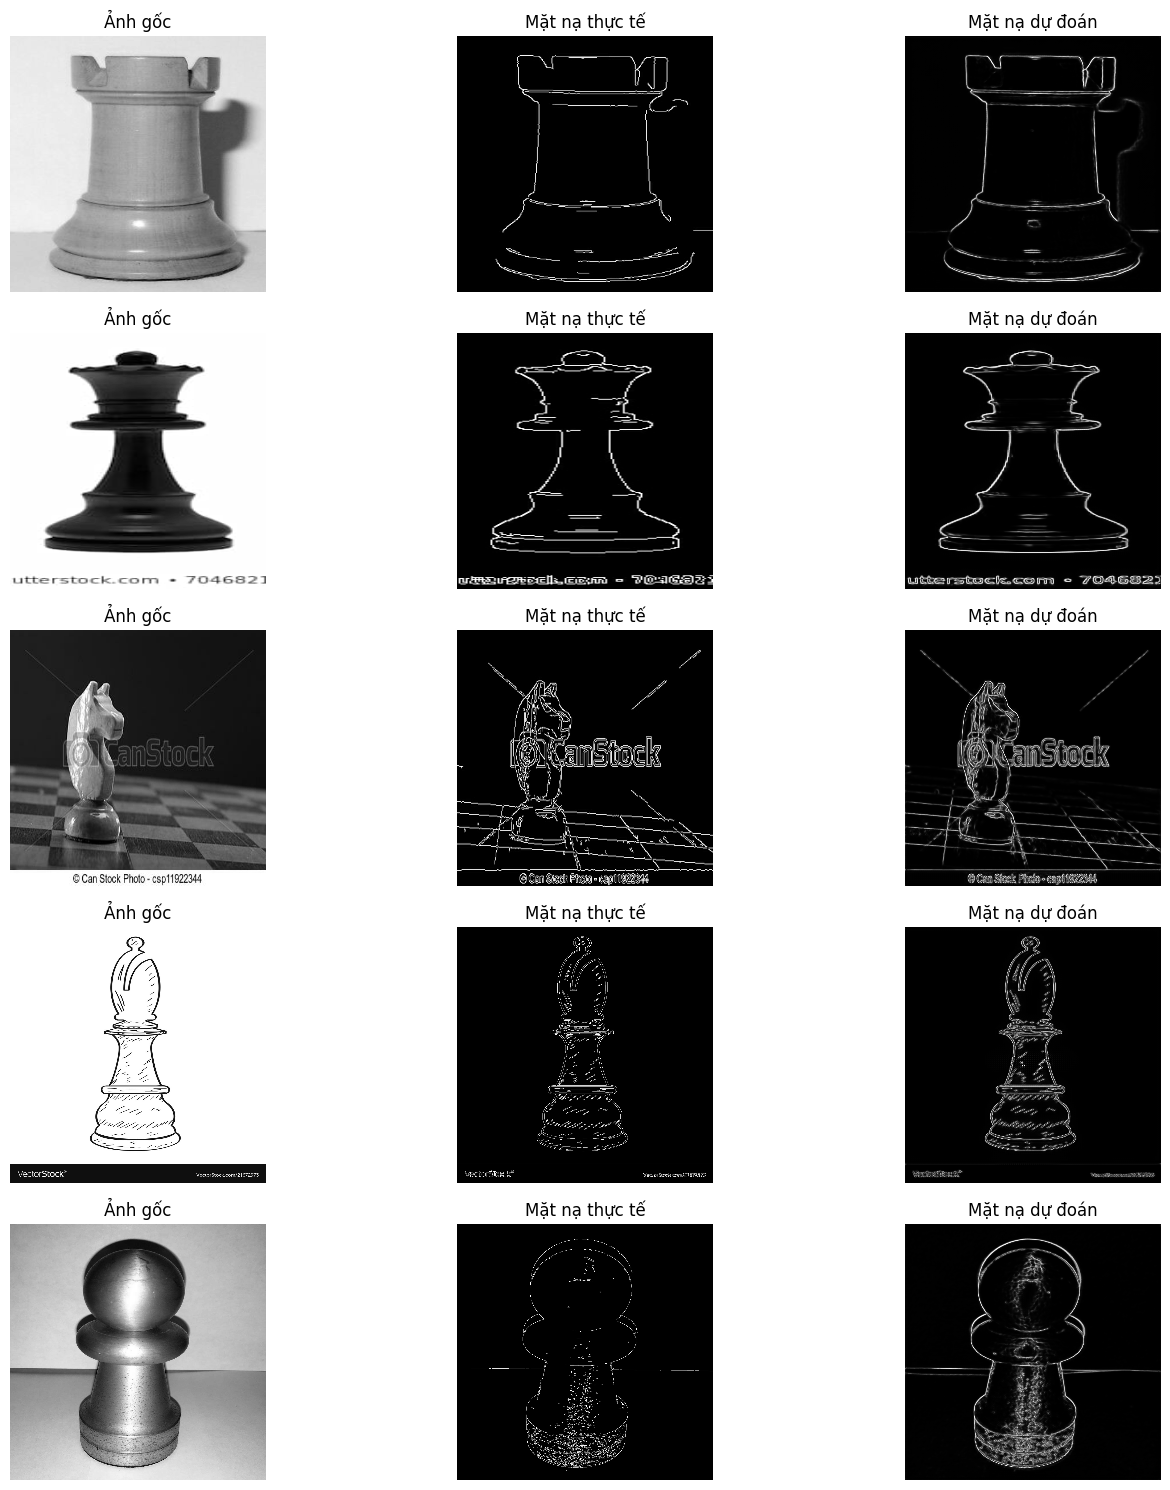

In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load pre-trained U-Net model
model_path = "/content/drive/MyDrive/chess/unet_model.h5"
model = tf.keras.models.load_model(model_path)

# Dự đoán trên tập kiểm tra
predictions = model.predict(test_dataset)

# Hiển thị một số ảnh và mặt nạ dự đoán
# Lấy một lô ảnh và mặt nạ từ tập kiểm tra
for test_images, test_masks in test_dataset.take(1):
    # Dự đoán mặt nạ cho các ảnh từ mô hình
    predicted_masks = model.predict(test_images)

    # Hiển thị một số cặp ảnh, mặt nạ thực tế và mặt nạ dự đoán
    n_images = 5
    plt.figure(figsize=(15, 15))
    for i in range(n_images):
        # Hiển thị ảnh gốc
        plt.subplot(n_images, 3, 3*i+1)
        # Convert the image to grayscale by averaging the color channels
        # or by selecting a single channel (e.g., test_images[i,:,:,0] for Red channel)
        gray_image = tf.reduce_mean(test_images[i], axis=-1) # Averaging all channels
        plt.imshow(gray_image.numpy().reshape(256, 256), cmap='gray')
        plt.title("Ảnh gốc")
        plt.axis('off')

        # Hiển thị mặt nạ thực tế
        plt.subplot(n_images, 3, 3*i+2)
        plt.imshow(test_masks[i].numpy().reshape(256, 256), cmap='gray')
        plt.title("Mặt nạ thực tế")
        plt.axis('off')

        # Hiển thị mặt nạ dự đoán
        plt.subplot(n_images, 3, 3*i+3)
        plt.imshow(predicted_masks[i].reshape(256, 256), cmap='gray')
        plt.title("Mặt nạ dự đoán")
        plt.axis('off')

    plt.tight_layout()
    plt.show()